# PeDistance Linear Regression

### Initial settings

#### Dependencies

In [1]:
# YOLOv5 install dependencies
%pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [2]:
#imutils
%pip install imutils

Note: you may need to restart the kernel to use updated packages.


#### Imports and Utilities

In [32]:
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import base64
from PIL import Image
import cv2
from pathlib import Path
from __future__ import print_function
import imutils
from imutils.object_detection import non_max_suppression
from imutils import paths
import argparse
import matplotlib.image as mpimg
import io

%matplotlib notebook

In [33]:
# Used as file name where saving model state
model_file_name="reg_state.pth"

# Get device based on available hardware
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# Convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.tensor(df.to_numpy()).float().to(device)

### Import Dataset

In [ ]:
# Filtered fields read from dataset csv file
fields = [
    'Distance',
    'Xmin', 
    'Ymin',
    'Xmax', 
    'Ymax',
    'B64File'
]

df = pd.read_csv (r'./yoloDataset.csv', usecols=fields)
print(df.shape)
print(df)

### Normalize input feature 

In [87]:
def get_image_resolution(b64string):
    image = base64.b64decode(b64string)
    image = io.BytesIO(image)
    image = mpimg.imread(image, format='JPG')
    return image.shape
    
testone = df['B64File'][0]    
get_image_resolution(testone)

(1080, 1920, 3)

### Splitting dataset


In [89]:
# sklearn function to split pandas dataframe into train and test set
train, test = train_test_split(df, test_size = 0.2)
train = shuffle(train)

In [90]:
# parsing dataframes to pytorch tensor
Y_training = df_to_tensor(train.Distance)
Y_testing = df_to_tensor(test.Distance)

print(Y_training.shape)
print(Y_testing.shape)

torch.Size([3505])
torch.Size([877])


#### Getting width  height from raw 2D screen points

In [91]:
def get_resized_box_dim(el):
    width = abs(el.Xmax - el.Xmin)
    height = abs(el.Ymax - el.Ymin)
    res = get_image_resolution(el.B64File)
    width = int((width * 640) / res[1])
    height = int((height * 360) / res[0])
    return width, height

In [92]:
X_training = df_to_tensor(train.apply(lambda el :  pd.Series(get_resized_box_dim(el), index=['width', 'height']), axis=1))
X_testing = df_to_tensor(test.apply(lambda el :  pd.Series(get_resized_box_dim(el), index=['width', 'height']), axis=1))

print(X_training.shape)
print(X_testing.shape)

torch.Size([3505, 2])
torch.Size([877, 2])


### Linear Regression Module

In [93]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        super(LinearRegressor, self).__init__()
        self.criterion = nn.MSELoss()
        self.linear = nn.Linear(in_size,out_size)       
        
    # used to train linear regressor
    def fit(self, X_training, Y_training, X_testing, Y_testing, lr= 0.001, epochs=40000, momentum=0.0, reset_parameters= False):
        self.reset_parameters(reset_parameters)
        
        self.mean = X_training.mean(0)
        self.stds = X_training.std(0)
        X_training_norm = self._data_normalization(X_training)
        X_testing_norm = self._data_normalization(X_testing)
                
        self.optimizer = torch.optim.SGD(reg.parameters(), lr=lr, momentum=momentum)
        self.writer = SummaryWriter('logs/linear_regressor_lr' + str(lr) + '_momentum' + str(momentum) + '_epochs' + str(epochs))
        
        self._training(X_training_norm, Y_training, X_testing_norm, Y_testing, lr, epochs, momentum)
       
    def _training(self, X_training_norm, Y_training, X_testing_norm, Y_testing, l, epochs, momentum):
       
        for e in range(epochs):   
            reg.train()
            preds_train = self.forward(X_training_norm)
            l = self.criterion(preds_train.view(-1),Y_training)

            self.writer.add_scalar('loss/train', l.item(), global_step=e)

            l.backward()

            self.optimizer.step()    
            self.optimizer.zero_grad()
            
            reg.eval()
            with torch.set_grad_enabled(False):
                preds_test = self.forward(X_testing_norm)
                l = self.criterion(preds_test.view(-1),Y_testing)
                self.writer.add_scalar('loss/test', l.item(), global_step=e)    
        
    # used to get prediction based on trained linear regressor
    def predict(self, X):  
        X_norm = self._data_normalization(X)
        return self.linear(X_norm)
       
    # used to get final score tensor and predicted tensor based on train or test features and labels
    def score(self, X, Y):
        Y_preds = self.predict(X)
        l = self.criterion(Y_preds.view(-1),Y)
        return l, Y_preds
    
    # used to reset parameters before training
    def reset_parameters(self, reset_parameters= False):
        if reset_parameters:
            for layer in self.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
    
    # used to load parameters and model state to make predictions or continue training
    def load_state(self, path):
        if Path(path).exists():
            checkpoint = torch.load(path, map_location=get_device())
            self.mean = checkpoint["mean"]
            self.stds = checkpoint["stds"]
            self.load_state_dict(checkpoint["model_state_dict"])
    
    # used to save trained model state
    def save_state(self, path):
         torch.save({
            'mean': self.mean,
            'stds': self.stds,
            'model_state_dict': self.state_dict(),
            }, path)
        
    def _data_normalization(self, data):
        return (data-self.mean)/self.stds        
    
    def forward(self,x):
        result = self.linear(x)
        return result    

### Modular Linear Regression

In [94]:
reg = LinearRegressor(2,1).to(get_device())

In [23]:
reg.load_state(model_file_name)

In [96]:
reg.fit(X_training, Y_training, X_testing, Y_testing, epochs=100000, reset_parameters=True)
reg.save_state(model_file_name)

In [104]:
print(X_training[0], Y_training[0])

tensor([17., 39.], device='cuda:0') tensor(18.58000, device='cuda:0')


In [73]:
%reload_ext tensorboard
%tensorboard --logdir ./logs --host localhost

### Accuracy

In [97]:
def rec_curve(predictions, gt):
    assert predictions.shape == gt.shape
    #calcoliamo tutti gli errori mediante MAE
    errors = np.abs(np.array((predictions.detach()-gt)))
    #prendiamo i valori unici degli erorri e ordiniamoli
    tolerances = sorted(np.unique(errors))
    correct= [] #lista delle "accuracy" relative a ogni soglia
    for t in tolerances:
        correct.append((errors<=t).mean()) #frazione di elementi "correttamente" regressi
    AUC = np.trapz(correct, tolerances) #area sotto la curva calcolata col metodo dei trapezi
    tot_area = np.max(tolerances)*1 #area totale
    AOC = tot_area - AUC
    #restituiamo le soglie, la frazione di campioni correttamente regressi e l'area sopra la curva
    return tolerances, correct, AOC

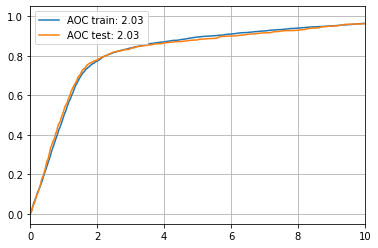

In [98]:
preds_training = reg.predict(X_training)
linear_regressor_rec = rec_curve(preds_training.view(-1).cpu(),Y_training.cpu())
plt.plot(linear_regressor_rec[0], linear_regressor_rec[1])

preds_testing = reg.predict(X_testing)
linear_regressor_rec_test = rec_curve(preds_testing.view(-1).cpu(),Y_testing.cpu())
plt.plot(linear_regressor_rec_test[0], linear_regressor_rec_test[1])
plt.legend(['AOC train: %0.2f'%linear_regressor_rec[2], 'AOC test: %0.2f'%linear_regressor_rec_test[2]])

plt.xlim(0, 10)
plt.grid()
plt.show()

## YOLOv5

In [99]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\danil/.cache\torch\hub\ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-6-21 torch 1.8.0 CUDA:0 (NVIDIA GeForce RTX 2060, 6144.0MB)



### Get boxes from image

In [100]:
# Images
# img = plt.imread('lena.png')
img = Image.open('cbimage.png').convert("RGB").resize((640,360))
#imgs = ['https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png']  # batch of images
# print(img.size)

# Inference
results = model(img)

# Salva i risultati nella cartella corrente, inutile 
# results.print()
# results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)

results.pandas().xyxy[0]  # img1 predictions (pandas)

,xmin,ymin,xmax,ymax,confidence,class,name
0,456.5,146.875,476.0,200.875,0.774902,0,person


### Get predictions

In [101]:
box_img = np.asarray(img)
person_box = []
person_box_size = []
obj_recognized = results.xyxy[0].cpu().numpy()
padding = 5 # pixels

for obj in obj_recognized:
    if obj[5] == 0:
        obj[0] = obj[0] - padding
        obj[1] = obj[1] - padding
        obj[2] = obj[2] + padding
        obj[3] = obj[3] + padding
        person_box.append([obj[0], obj[1], obj[2], obj[3]])   
        person_box_size.append([abs(obj[2] - obj[0]), abs(obj[3] - obj[1])])

y_pred = reg.predict(torch.tensor(person_box_size).to(get_device())).squeeze(1).cpu().detach().numpy()
print(y_pred)
data = pd.DataFrame({'Prediction (m)': y_pred})
print(data)

[     11.472]
   Prediction (m)
0       11.472229


### Drawing boxes

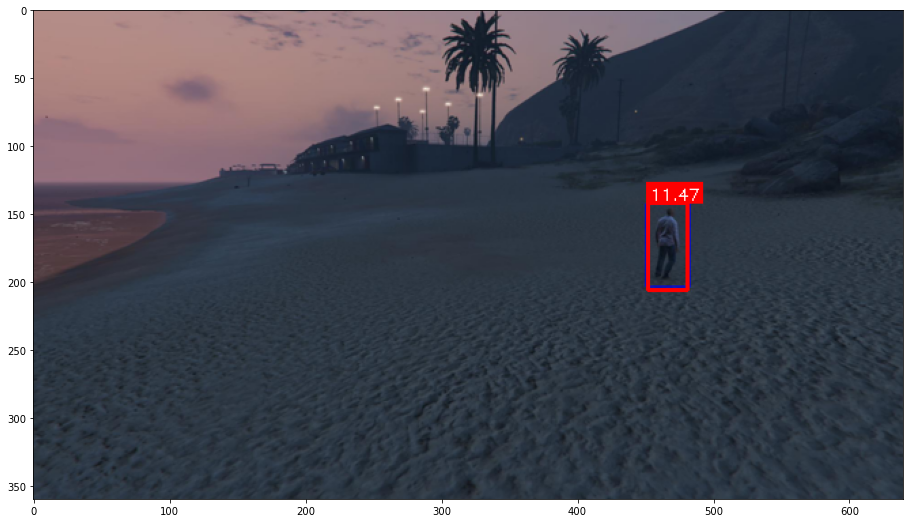

In [102]:
boxes = np.column_stack((person_box, y_pred))

for box in boxes:   
    cv2.rectangle(box_img, (round(box[0]),round(box[1])), (round(box[2]),round(box[3])), (255, 0, 0), 2)
    cv2.rectangle(box_img, (round(box[0]) - 1, round(box[1]) - 15), (round(box[0]) + 40, round(box[1])), (255, 0, 0), -1)
    cv2.putText(box_img, str(round(box[4], 2)), (round(box[0]) + 2, round(box[1]) - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(box_img)